<a href="https://colab.research.google.com/github/ariaghora/notebooks/blob/master/MIL_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade git+https://github.com/ariaghora/abon_toolkit.git

  Cloning https://github.com/ariaghora/abon_toolkit.git to /tmp/pip-req-build-u19qlqwu
  Running command git clone -q https://github.com/ariaghora/abon_toolkit.git /tmp/pip-req-build-u19qlqwu
  Created wheel for abon-toolkit: filename=abon_toolkit-1.0.0-cp36-none-any.whl size=2433 sha256=1bdafe49599bc2638ee59f18e285c5d87a1e11daf52634982536c10b76e8dd7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xapel9ml/wheels/ec/70/08/fa3f588a08eede3d7f1fb1b05abd42a8af061a3ce539d8c9f6
Successfully built abon-toolkit


In [0]:
import json
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from functools import partial
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from torch import nn
from tqdm import tqdm_notebook
from IPython import display

from abon_toolkit.kernels import rbf_kernel
from abon_toolkit.preprocessing import minibatchify

data_dsa = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dsa_dataset_clean.csv', header=None).values
data_opp = pd.read_csv('/content/drive/My Drive/Colab Notebooks/opportunity_dataset_clean.csv', header=None).values
data_pam = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pamap_dataset_clean.csv', header=None).values
data_mhe = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mhealth_dataset_clean.csv', header=None).values

# Model & function defs

In [0]:
def relation_mat(orig):
    return 1/torch.exp(l2_norm(orig, orig))

def structural_loss(latent, W):
    norm = l2_norm(latent, latent)
    return (norm @ W).mean()

def equi_width_split(x, width):
    X = np.array([np.array(t) for t in zip(*[iter(x)]*width)])
    return X

def create_bags(x, sensor_freq, exp_sampling_sec):
    return np.transpose(equi_width_split(equi_width_split(x, sensor_freq), exp_sampling_sec), (0, 1, 3, 2))

def create_bag_labels(x, sensor_freq, exp_sampling_sec):
    res = equi_width_split(equi_width_split(x, sensor_freq), exp_sampling_sec)
    res = res.reshape(res.shape[0], -1)
    out = []
    for y in res:
        out.append(stats.mode(y)[0][0])
    return np.array(out)

def mmd_rbf(x, y, deg=2):
    m = x.shape[0]
    n = y.shape[0]
    return (
        (torch.sum(rbf_kernel(x, x)) / (m**2)) - 
        (torch.sum(rbf_kernel(x, y)) * (2 / (m*n))) + 
        (torch.sum(rbf_kernel(y, y)) / (n**2)))

def random_sample_bag(x, y, n_sample):
    idx = list(range(x.shape[0]))
    np.random.shuffle(idx)
    return x[idx[:n_sample]], y[idx[:n_sample]]

class MILAE:

    def __init__(self, x_src, y_src, x_tar, y_tar, uses_mil_pooling=True, 
                 alpha=1, beta=1):
        self.x_src = x_src 
        self.y_src = y_src
        self.x_tar = x_tar
        self.y_tar = y_tar
        
        self.alpha = alpha
        self.beta  = beta
        self.uses_mil_pooling = uses_mil_pooling

        self.mse_loss = nn.MSELoss().cuda()
        self.ce_loss = nn.CrossEntropyLoss().cuda()
        self.hinge = nn.HingeEmbeddingLoss().cuda()

        self.reinitialize()
    
    def reinitialize(self):
        h1, h2, h3 = 512, 256, 128
        self.enc = self.Encoder(self.x_tar.shape[2], h1, h2, h3).cuda()
        self.dec = self.Decoder(self.x_tar.shape[2], h1, h2, h3).cuda()
        self.opt_ae = torch.optim.Adam([*self.enc.parameters(), 
                                        *self.dec.parameters()],
                                        lr=0.00001)
        
        '''
        Precompute MLP input neuron size
        '''
        with torch.no_grad():
            h_src = self.enc(self.x_tar[:batch_size])
            if self.uses_mil_pooling:
                res = h_src.contiguous().view(h_src.shape[0], h_src.shape[1], -1)
                res = torch.mean(res, 1)
            else:
                res = h_src.contiguous().view(h_src.shape[0], -1)
            n_input = res.shape[1]

        self.clf = self.MLP(n_input, 
                            uses_mil_pooling=self.uses_mil_pooling, 
                            alpha=self.alpha,
                            beta=self.beta).cuda()
        self.opt_clf = torch.optim.Adam([
                                         *self.clf.parameters(), 
                                        #  *self.enc.parameters()
                                         ], 
                                        lr=0.00001)
        
        del h_src, res
    
    def train_autoencoder(self, n_epoch=100, show_report=False, show_graph=False):
        '''
        Autoencder training with target dataset
        '''
        epoch_losses = []
        minibatches = minibatchify(self.x_tar, batch_size=batch_size)
        for j in range(0, n_epoch):
            batch_losses = []
            for i in range(0, len(self.x_tar), batch_size):
                x = self.x_tar[i:i+batch_size]
                pred = self.dec(self.enc(x))

                self.opt_ae.zero_grad()
                loss = self.mse_loss(pred, x) 
                loss.backward()
                self.opt_ae.step()

                batch_losses.append(loss.item())
            mean_batch_loss = np.mean(batch_losses)
            epoch_losses.append(mean_batch_loss)

            if show_report:
                display.clear_output(wait=True)
                print(f'\rEpoch {j + 1}/{n_epoch}, ' + 
                      f'mean loss: {mean_batch_loss}', 
                      end='')
                if show_graph:
                    plt.plot(epoch_losses)
                    plt.show()
        
        self.autoencoder_losses = epoch_losses
    
    def train_mlp(self, n_epoch=100, show_report=False, show_graph=False):
        epoch_losses_clf = []
        accs = []

        minibatches = minibatchify(self.x_src, self.y_src, batch_size=batch_size)

        for j in range(0, n_epoch):
            batch_losses = []
            b_count = 0
        
            lmb = (n_epoch-j)/n_epoch
            for x, y in minibatches:
                h_src = self.enc(x)
                pred_src, z_src = self.clf(h_src)

                x_tar_, _ = random_sample_bag(self.x_tar, self.y_tar, batch_size)
                h_tar = self.enc(x_tar_)
                pred_tar, z_tar = self.clf(self.enc(x_tar_))

                W1t = rbf_kernel(h_tar.contiguous().view(h_tar.shape[0], -1), 
                                 h_tar.contiguous().view(h_tar.shape[0], -1))
                W2t = rbf_kernel(z_tar, z_tar)
                sloss_t = self.hinge(W1t, W2t)

                W1s = rbf_kernel(h_src.contiguous().view(h_src.shape[0], -1), 
                                 h_src.contiguous().view(h_src.shape[0], -1))
                W2s = rbf_kernel(z_src, z_src)
                sloss_s = self.hinge(W1s, W2s)

                self.opt_clf.zero_grad()
                loss = self.ce_loss(pred_src, y) + (self.alpha * mmd_rbf(z_src, z_tar) + self.beta * (sloss_s + sloss_t))
                loss.backward()
                self.opt_clf.step()

                batch_losses.append(loss.item())


            mean_batch_loss = np.mean(batch_losses)                    
            epoch_losses_clf.append(mean_batch_loss)

            if show_report:
                with torch.no_grad():
                    # print(j+1,' (', mean_batch_loss, ')================================')
                    pred_label_src = self.predict(x_src).detach().cpu()
                    pred_label_tar = self.predict(x_tar).detach().cpu()

                display.clear_output(wait=True)
                print(f'\rEpoch {j + 1}/{n_epoch}, ' + 
                        f'src acc: {accuracy_score(pred_label_src, self.y_src.cpu())}, ' +
                        f'tar acc: {accuracy_score(pred_label_tar, self.y_tar.cpu())}', 
                        end='')

                if show_graph:
                    print(classification_report(pred_label_src, self.y_src.cpu()))
                    print(classification_report(pred_label_tar, self.y_tar.cpu()))

                    accs.append(accuracy_score(pred_label_tar, self.y_tar.cpu()))

                    plt.plot(epoch_losses_clf)
                    plt.show()

                    plt.plot(accs)
                    plt.show()
                
        self.mlp_losses = epoch_losses_clf
        self.accuracies = accs

    def predict(self, x):
        return self.clf(self.enc(x))[0].argmax(1)


    class Encoder(nn.Module):
        def __init__(self, in_channels, h1, h2, h3):
            super(MILAE.Encoder, self).__init__()
            
            self.c1 = nn.Conv1d(in_channels, h1, 3)
            self.c2 = nn.Conv1d(h1, h2, 3)
            self.c3 = nn.Conv1d(h2, h3, 3)
            self.act = nn.ELU()
            
        def forward(self, x):
            out = []
            for x_ in x:
                res = self.act(self.c1(x_))
                res = self.act(self.c2(res))
                res = self.act(self.c3(res))
                out.append(res)
            return torch.stack(out)

    class Decoder(nn.Module):
        def __init__(self, out_channels, h1, h2, h3):
            super(MILAE.Decoder, self).__init__()
            self.c1 = nn.ConvTranspose1d(h3, h2, 3)
            self.c2 = nn.ConvTranspose1d(h2, h1, 3)
            self.c3 = nn.ConvTranspose1d(h1, out_channels, 3)
            self.act = nn.ELU()
            
        def forward(self, x):
            out = []
            for x_ in x:
                res = self.act(self.c1(x_))
                res = self.act(self.c2(res))
                res = self.c3(res)
                out.append(res)
            return torch.stack(out)
    
    class MLP(nn.Module):
        def __init__(self, input_size, uses_mil_pooling, alpha, beta):
            super(MILAE.MLP, self).__init__()
            self.fc1 = nn.Linear(input_size, 1024)
            self.fc2 = nn.Linear(1024, 512)
            self.fc3 = nn.Linear(512, 256)
            self.fc4 = nn.Linear(256, 4)
            self.act = nn.ELU()
            self.sm  = nn.Softmax(1)
            self.alpha = alpha
            self.beta  = beta
            self.uses_mil_pooling = uses_mil_pooling

        def forward(self, x):
            if self.uses_mil_pooling:
                res = x.contiguous().view(x.shape[0], x.shape[1], -1)
                # res = torch.max(res, 1).values
                res = torch.mean(res, 1)
            else:
                res = x.contiguous().view(x.shape[0], -1)

            res = self.act(self.fc1(res))
            res = self.act(self.fc2(res)); z = res
            res = self.act(self.fc3(res))
            res = self.sm(self.fc4(res))

            return res, z

In [0]:
col_dsa = [
    *range(0, 9), # Torso
    *range(9, 18), # Right arm
    *range(18, 27), # Left arm 
    *range(27, 36), # Right leg
    *range(36, 45), # Left leg
]

col_opp = [
    *range(0, 9), # Back
    *range(9, 18), # RUA
    *range(18, 27), # RLA
    *range(27, 36), # LUA
    *range(36, 45), # LLA
]

'''
DSA per-part
'''
dsa_x_all = data_dsa[:, :-1]
dsa_x_all = StandardScaler().fit_transform(dsa_x_all)
dsa_x = dsa_x_all[:, col_dsa]
dsa_y = data_dsa[:, -1]

dsa_t  = dsa_x_all[:, range(0, 9)]
dsa_ra = dsa_x_all[:, range(9, 18)]
dsa_la = dsa_x_all[:, range(18, 27)]
dsa_rl = dsa_x_all[:, range(27, 36)]
dsa_ll = dsa_x_all[:, range(36, 45)]
    
dsa_common = dsa_x_all[:, [
                           *range(0, 9), # Torso
                           *range(18, 27), # Left arm 
                           *range(9, 18), # Right arm
                           ]]

'''
OPP per-part
'''
opp_x_all = data_opp[:, :-1]

opp_x_all = StandardScaler().fit_transform(opp_x_all)
opp_x = opp_x_all[:, col_opp]
opp_y = data_opp[:, -1]

opp_y     = opp_y[~np.isnan(opp_x_all).any(axis=1)]
opp_x_all = opp_x_all[~np.isnan(opp_x_all).any(axis=1)]

opp_b   = opp_x_all[:, range(0, 9)]
opp_lua = opp_x_all[:, range(27, 36)]
opp_rua = opp_x_all[:, range(18, 27)]
opp_rla = opp_x_all[:, range(9, 18)]
opp_lla = opp_x_all[:, range(36, 45)]

opp_common = opp_x_all[:, [
                           *range(0, 9), # Back
                           *range(36, 45), # LLA
                           *range(18, 27), # RLA
                           ]]

'''
PAMAP per-part
'''
col_pam = [
    *range(0, 9), # hand
    *range(9, 18), # chest
    *range(18, 27), # ankle
]

pam_x_all = data_pam[:, :-1]
pam_x_all = StandardScaler().fit_transform(pam_x_all)

pam_h = pam_x_all[:, range(0, 9)]
pam_c = pam_x_all[:, range(9, 18)]
pam_a = pam_x_all[:, range(18, 27)]
pam_y = data_pam[:, -1]

'''
MHEALTH per-part
'''
col_mhe = [
    *range(0, 9), # left ankle
    *range(9, 18), # right lower arm
]

mhe_x_all = data_mhe[:, :-1]
mhe_x_all = StandardScaler().fit_transform(mhe_x_all)

mhe_lan = mhe_x_all[:, range(0, 9)]
mhe_rla = mhe_x_all[:, range(9, 18)]
mhe_y = data_mhe[:, -1]

# Experiment configs

In [0]:
NUM_SAMPLE_PER_INSTANCE = 3 #seconds :p
DSA_FREQ = 30
OPP_FREQ = 30
BAG_SIZE = 10

config = {
    'n_epoch': 70,
    'batch_size': 64,
    'lr': 0.00001,
    'alpha': 0.01,
    'beta': 0.01,
    'x_src': 'pam_c',
    'y_src': 'pam_y',
    'x_tar': 'pam_a',
    'y_tar': 'pam_y',
}

#Initialization

In [0]:
'''
Read configs
'''
alpha      = config['alpha']
beta       = config['beta']
batch_size = config['batch_size']
lr         = config['lr']
n_epoch    = config['n_epoch']


x_src = eval(config['x_src'])
y_src = eval(config['y_src'])
x_tar = eval(config['x_tar'])
y_tar = eval(config['y_tar'])

x_src = torch.from_numpy(create_bags(x_src, DSA_FREQ * NUM_SAMPLE_PER_INSTANCE, BAG_SIZE)).float()
y_src = torch.from_numpy(create_bag_labels(y_src, DSA_FREQ * NUM_SAMPLE_PER_INSTANCE, BAG_SIZE)).long()
x_tar = torch.from_numpy(create_bags(x_tar, OPP_FREQ * NUM_SAMPLE_PER_INSTANCE, BAG_SIZE)).float()
y_tar = torch.from_numpy(create_bag_labels(y_tar, OPP_FREQ * NUM_SAMPLE_PER_INSTANCE, BAG_SIZE)).long()

y_src_bin = torch.from_numpy(LabelBinarizer().fit_transform(y_src)).float()
y_tar_bin = torch.from_numpy(LabelBinarizer().fit_transform(y_tar)).float()

x_src = x_src.cuda()
x_tar = x_tar.cuda()
y_src_bin = y_src_bin.cuda()
y_tar_bin = y_tar_bin.cuda()

y_src = y_src.cuda()
y_tar = y_tar.cuda()

# Training: Proposed model

Epoch 100/100, mean loss: 0.05637317057698965

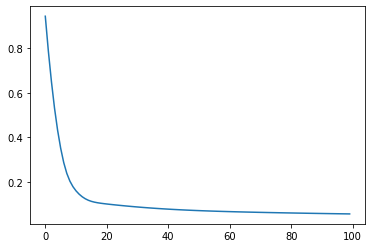

In [0]:
torch.manual_seed(0)
np.random.seed(0)
milae = MILAE(x_src, y_src, x_tar, y_tar, uses_mil_pooling=True)
milae.train_autoencoder(n_epoch=100, show_report=True, show_graph=True)

Epoch 200/200, src acc: 0.9479638009049773, tar acc: 0.6221719457013575              precision    recall  f1-score   support

           0       1.00      0.94      0.97       224
           1       0.99      0.90      0.95       277
           2       0.86      0.97      0.91       182
           3       0.93      1.00      0.96       201

    accuracy                           0.95       884
   macro avg       0.95      0.95      0.95       884
weighted avg       0.95      0.95      0.95       884

              precision    recall  f1-score   support

           0       0.68      0.56      0.62       259
           1       0.68      0.70      0.69       244
           2       0.31      0.34      0.32       183
           3       0.80      0.86      0.83       198

    accuracy                           0.62       884
   macro avg       0.62      0.62      0.61       884
weighted avg       0.63      0.62      0.62       884



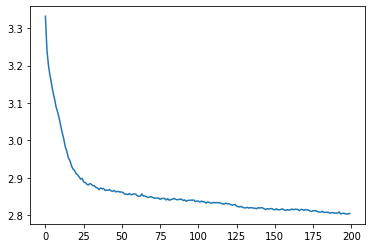

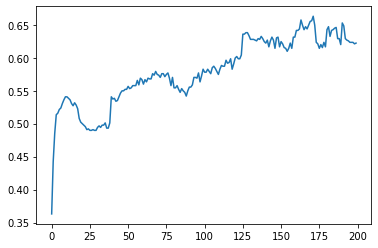

In [0]:
milae.alpha = 1
milae.beta  = 1
milae.train_mlp(n_epoch=200, show_report=True, show_graph=True)

In [0]:
from sklearn.metrics import f1_score
pred_label_tar = milae.predict(x_tar).detach().cpu()

acc = accuracy_score(pred_label_tar, y_tar.cpu())
f1_mic = f1_score(pred_label_tar, y_tar.cpu(), average='micro')
f1_mac = f1_score(pred_label_tar, y_tar.cpu(), average='macro')
f1_wei = f1_score(pred_label_tar, y_tar.cpu(), average='weighted')

print(f'acc: {acc}, f1-mic: {f1_mic}, f1-mac: {f1_mac}, f1-wei: {f1_wei}')

acc: 0.6221719457013575, f1-mic: 0.6221719457013575, f1-mac: 0.6145142041994102, f1-wei: 0.6234165656704613


# Experiments and toys goes here

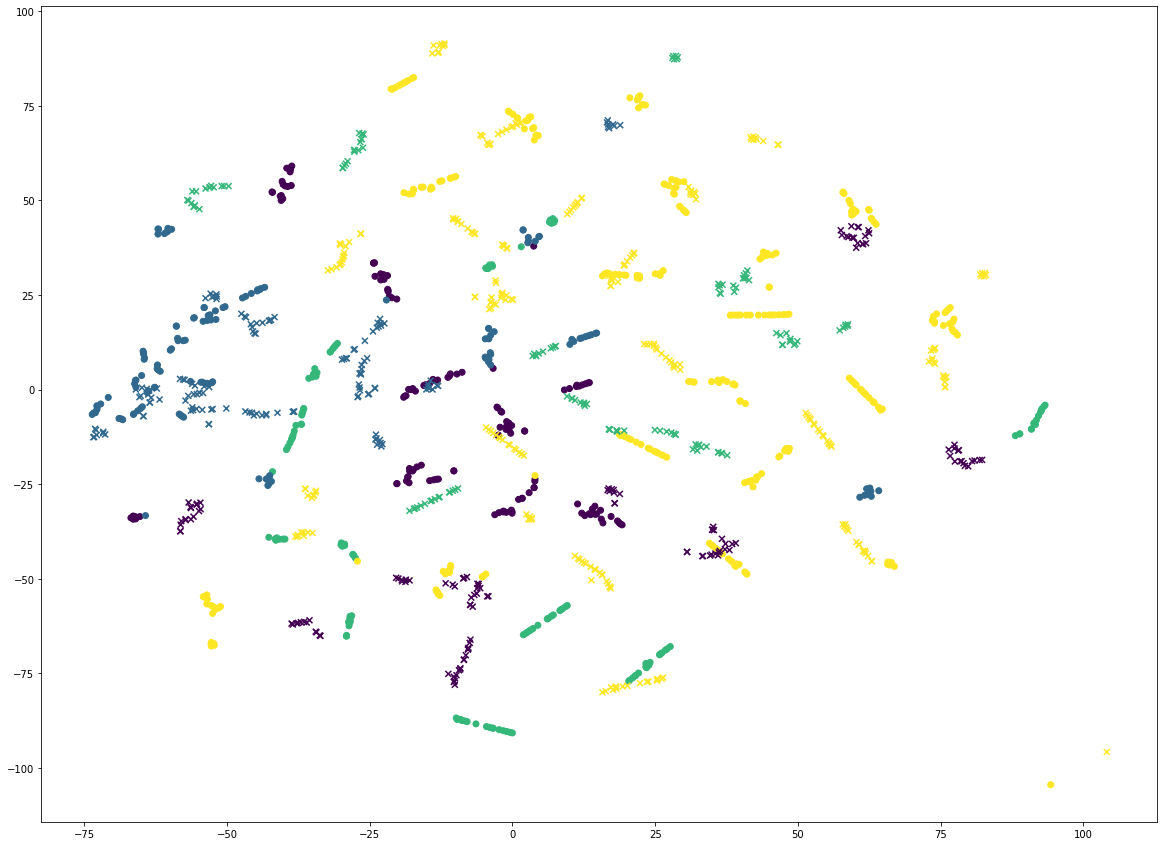

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 15]

with torch.no_grad():
    x_ori = enc(x_tar)
    x_ori_ = x_ori.view(x_ori.shape[0], -1).cpu().numpy()
    _, z  = clf(x_ori)
    z = z.cpu().numpy()

    x, y = [*TSNE(init='random', perplexity=5).fit_transform(z).T]
    # x, y = [*KernelPCA(2, kernel='rbf').fit_transform(z).T]
    plt.scatter(x, y, c=y_tar.cpu())    

    x_ori = enc(x_src)
    x_ori_ = x_ori.view(x_ori.shape[0], -1).cpu().numpy()
    _, z  = clf(x_ori)
    z = z.cpu().numpy()

    x, y = [*TSNE(init='random', perplexity=5).fit_transform(z).T]
    # x, y = [*KernelPCA(2, kernel='rbf').fit_transform(z).T]
    plt.scatter(x, y, c=y_src.cpu(), marker='x')    
    plt.show()


In [0]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(milae, label='Proposed')
plt.plot(accs_without, label='MI-Net')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Testing accuracy')

AttributeError: ignored

Text(0, 0.5, 'Training loss')

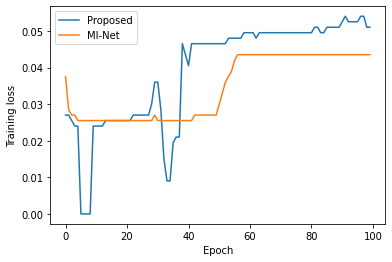

In [0]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(milae.accuracies, label='Proposed')
plt.plot(milae2.accuracies, label='MI-Net')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training loss')

Text(0, 0.5, 'Training loss')

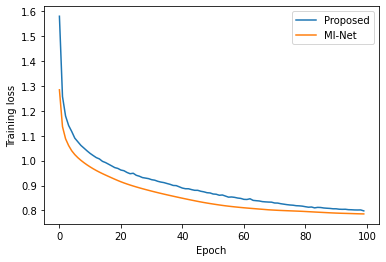

In [0]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(milae.mlp_losses, label='Proposed')
plt.plot(milae2.mlp_losses, label='MI-Net')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training loss')

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr 16 01:51:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
list(minibatchify(x_src, y_src))[0][1] == list(minibatchify(x_src, y_src))[1][1]

tensor([False, False,  True, False, False, False, False,  True, False, False,
         True, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False], device='cuda:0')

In [0]:
data_mhe.shape[0]

122880